# 프로젝트 :ResNet Ablation STudy

### 1) ResNet 기본 블록 구성하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

dataset_name = 'cats_vs_dogs'
ds_train, ds_info_train = tfds.load(name=dataset_name, split='train[:80%]', as_supervised=True, with_info=True)
ds_valid, ds_info_valid = tfds.load(name=dataset_name, split='train[80%:]', as_supervised=True, with_info=True)

In [4]:
# label 확인
ds_info_train.features["label"].num_classes
ds_info_valid.features["label"].names

['cat', 'dog']

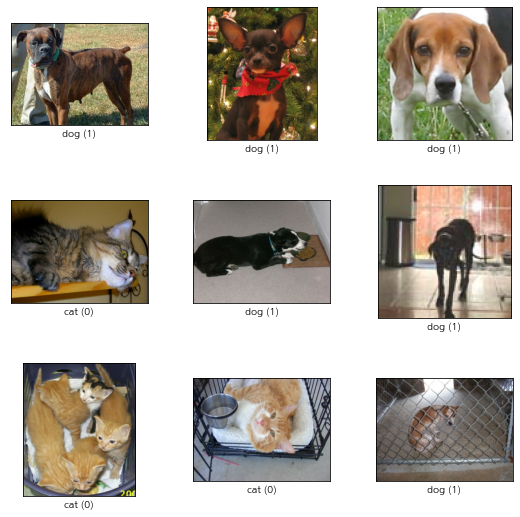

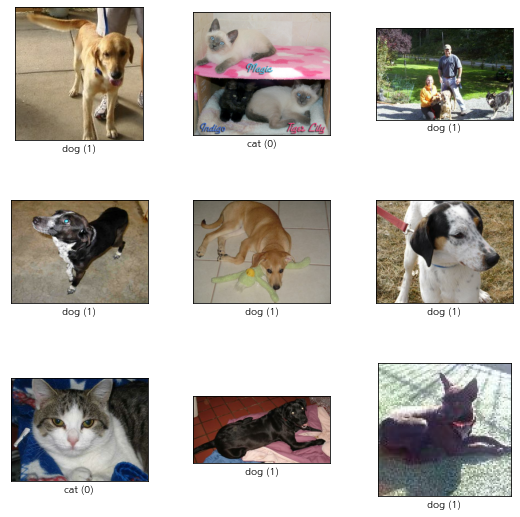

In [5]:
# 시각화 
fig = tfds.show_examples(ds_train, ds_info_train)
fig = tfds.show_examples(ds_valid, ds_info_valid)

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# # ResNet34
# def ResNet34(input_shape=(32,32,3), classes=6):
# X_input = tf.keras.layers.Input(input_shape)
# # zero padding
# X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
# # stage 1
# X = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, name='conv1',
# kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
# X = tf.keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
# X = tf.keras.layers.Activation('relu')(X)
# X = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2))(X)
# # stage 2
# X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block='a', s=1)
# X = identity_block(X, 3, [64,64,256], stage=2, block='b')
# X = identity_block(X, 3, [64,64,256], stage=2, block='c')
# # stage 3
# X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
# X = identity_block(X, 3, [128, 128, 512], stage = 3, block='b')
# X = identity_block(X, 3, [128, 128, 512], stage = 3, block='c')
# X = identity_block(X, 3, [128, 128, 512], stage = 3, block='d')
# # Stage 4
# X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
# X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='b')
# X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='c')
# X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='d')
# X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='e')
# X = identity_block(X, 3, [256, 256, 1024], stage = 4, block='f')
# # Stage 5
# X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
# X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='b')
# X = identity_block(X, 3, [512, 512, 2048], stage = 5, block='c')
# # AVGPOOL
# X = tf.keras.layers.AveragePooling2D()(X)
# # output layer
# X = tf.keras.layers.Flatten()(X)
# X = tf.keras.layers.Dense(classes, activation='softmax', name='fc'+str(classes),
# kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
# # Create Model
# model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')
# return model


2) ResNet-34, ResNet-50 Complete Model
ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

In [9]:
def conv1(x): 
    # Conv2D
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2,2),
        kernel_initializer='he_normal',
        padding='same', name='conv2d_7x7'
    )(x)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    # maxpooling
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2,
             name='stage2_0_maxpooling'
            )(x)
    
    return x

In [10]:
def conv_short(x,filters,stage_num,block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(2,2),
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization()(x)
    
    return x

In [11]:
def conv_short50(x,filters, stage_num, block_num):
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=(1,1),
        kernel_initializer='he_normal',
        padding='same', strides=(1,1), 
        name=f'stage{stage_num}_{block_num+1}_short'
    )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn4')(x)
    
    return x

In [12]:
def conv_master1(x,
                 first_layer,
                 block_num,
                 kernel_size,
                 filters,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    """
    conv2
    1) layer-18: [[3*3],64, [3*3],64]*2
    2) layer-34: [[3*3],64, [3*3],64]*3
    3) layer-50: [[1*1],64, [3*3],64, [1*1],256]
    """
    
    # residual 정의
    residual = x
    
    if num_layer == 18 or num_layer == 34:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv2'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        
        if not is_plain:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    else:
        # 3개 층 중에서 첫번째 층만 shortcut이고 나머지 두 개는 입력값을 그대로 사용
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[0],
            kernel_initializer='he_normal',
            padding='same', name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size[1],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters*4, # 마지막 레이어는 4배이다.
            kernel_size=kernel_size[2],
            kernel_initializer='he_normal', name=f'stage{stage_num}_{block_num+1}_conv3',
            padding='same'
        )(x)
        
        # short
        conv3_short = conv_short50(residual, filters=filters*4, stage_num=stage_num, block_num=block_num)
        
        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn3')(x)
        
        if not is_plain:
            if first_layer:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
            else:
                # add
                x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])
            
        # activation
        x = tf.keras.layers.Activation('relu')(x)
        
    return x

In [13]:
def conv_master2(x,
                 block_num,
                 kernel_size,
                 filters,
                 first_layer, # True/False,
                 stage_num,
                 num_layer=34,
                 is_plain=False
                 ):
    
    residual = x
    
    # kernel_size_copy
    if num_layer == 50 or num_layer == 101 or num_layer == 152:
        kernel_size_copy = kernel_size.copy()
        kernel_size = kernel_size_copy[0]
        
    # <!-- first block --!>    
    # 첫 번재 층은 stride를 해야 함.
    if first_layer:
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same', strides=(2,2), # stride
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    else:
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_{block_num+1}_conv1'
        )(x)
    
    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)

    # Activation
    x = tf.keras.layers.Activation('relu')(x)

    if num_layer==50 or num_layer==101 or num_layer==152: 
        # <!-- second block --!>
        kernel_size = kernel_size_copy[1]
#         print(f'stage{stage_num}_{block_num+1}_conv2')
#         print('kernel_size: ', kernel_size)
        # Conv2D
        x = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv2',
            padding='same'
        )(x)

        # Batch Normalization 
        x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)

        # Activation
        x = tf.keras.layers.Activation('relu')(x)
    
    
    # <!-- third block --!>
#     print(f'stage{stage_num}_{block_num+1}_conv2')
#     print('kernel_size: ', kernel_size)
    conv_num=3
    if num_layer==50 or num_layer==101 or num_layer==152:
        filters=filters*4
        kernel_size = kernel_size_copy[2]
    else: conv_num-=1
    
    
    # Conv2D
    x = keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',name=f'stage{stage_num}_{block_num+1}_conv{conv_num}',
        padding='same'
    )(x)

    # short
    conv3_short = conv_short(residual, filters, stage_num=stage_num, block_num=block_num)
    conv3_short50 = conv_short50(residual, filters, stage_num=stage_num, block_num=block_num)

    # Batch Normalization 
    x = tf.keras.layers.BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn{conv_num}')(x)
    
    if not is_plain:
        if first_layer:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, conv3_short])
        else:
            # add
            x = tf.keras.layers.Add(name=f'stage{stage_num}_{block_num+1}_add')([x, residual])

    # activation
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [14]:
# 2) ResNet-34, ResNet-50 Complete Model
# ResNet-34
# VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

# 다음의 코드를 실행하면,

# resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
# resnet_34.summary()

In [15]:
def build_resnet(input_layer, num_layer=34, is_residual=True, is_plain=False):
    
    # layer개수에 따른 cnn층 개수
    cnn_layer ={
                18 : [2,2,2,2], 
                34 : [3,4,6,3], 
                50 : [3,4,6,3], 
                101 : [3,4,23,3],
                152 : [3,8,36,3]
                }
    
    # layer개수에 따른 filter 리스트
    filter_list = [64, 128, 256, 512]
    
    # layer별 커널 사이즈
    kernel_size_dict = {18:(3,3),
                   34:(3,3),
                   50:[(1,1),(3,3),(1,1)],
                   101:[(1,1),(3,3),(1,1)],
                   152:[(1,1),(3,3),(1,1)]}
    
    # layer별 커널 사이즈
    kernel_size = kernel_size_dict[num_layer]
    
    # cnn층 블록 개수 리스트(num_cnn_list) 할당
    num_cnn_list = cnn_layer[num_layer]
    
    # 전체 conv 블록 개수
    num_conv = len(num_cnn_list)
    
    # 입력 레이어
    x = input_layer
    
    # 7*7, 64, stride2 + maxpooling
    x = conv1(x)
    
    # stage num 정의
    stage_num = 2
    
    # conv_idx 정의
    conv_idx=0

    # conv2_x
    
    # layer-50,101,152만 해당
    first_layer = [True,False,False]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master1(x,
                         first_layer=first_layer[i],
                         block_num=i,
                         kernel_size=kernel_size,
                         filters=filter_list[conv_idx],
                         stage_num=stage_num,
                         num_layer=num_layer,
                         is_plain=is_plain
                         )

    # conv3_x
    stage_num+=1
    conv_idx+=1
    if is_residual: # residual 있을때
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:          # residual 없을때
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)
        


    # conv4_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
#     print('first_layer: ',first_layer)
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)

    # conv5_x
    stage_num+=1
    conv_idx+=1
    
    if is_residual:
        first_layer = [True]
        for _ in range(num_cnn_list[conv_idx]-1): first_layer.extend([False])
    else:
        first_layer = [False]*num_cnn_list[conv_idx]
    
    for i in range(num_cnn_list[conv_idx]):
        x = conv_master2(x,
                        block_num=i,
                        kernel_size=kernel_size,
                        filters=filter_list[conv_idx],
                        first_layer=first_layer[i],
                        stage_num=stage_num,
                        num_layer=num_layer,
                        is_plain=is_plain)


    # avg pooling
    x= keras.layers.AveragePooling2D(
        pool_size=(2, 2), strides=2, padding='SAME', name='avg_pool')(x)
    
    # flatten
    x = keras.layers.Flatten(name='flatten_11')(x)
    
    # FC layer(2) --- 우리가 사용할 데이터는 '고양이', '개' 두 가지 클래스만 있으므로 이걸 사용해야함.
    x = keras.layers.Dense(2,name='fc2')(x)
    
    # FC layer(10) --- 노드의 파라미터 확인용(cifar-10일 때는 이것을 사용해야함) 확인이 끝난 후에는 다시 주석 처리했음.
#     x = keras.layers.Dense(10,name='fc2')(x)
    
    return x

In [16]:
BATCH_SIZE = 16
EPOCH = 20

# 데이터 정의
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE)

In [17]:
resnet34_input_layer = keras.layers.Input(shape=(224,224,3), name='input_layer')   # 입력 레이어 생성 = (224,224,3)
resnet34_block_output = build_resnet(resnet34_input_layer)


resnet34 = keras.Model(inputs=resnet34_input_layer, outputs=resnet34_block_output)
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7x7 (Conv2D)             (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d_7x7[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

# history_34 = resnet34.fit(
#     ds_train,
#     steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     use_multiprocessing=True,
# )

In [23]:
history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [409,336,3], [batch]: [262,350,3]
	 [[node IteratorGetNext (defined at <ipython-input-19-1ad1a697d41d>:8) ]]
	 [[IteratorGetNext/_7]]
  (1) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [409,336,3], [batch]: [262,350,3]
	 [[node IteratorGetNext (defined at <ipython-input-19-1ad1a697d41d>:8) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_12543]

Function call stack:
train_function -> train_function


ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

다음의 코드를 실행하면, 아래의 결과가 나와야 합니다.

resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

3) 일반 네트워크(plain network) 만들기
블록 코드 수정하기
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

Ablation Study
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

시각화
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

추가 실험
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.